In [1]:
import logging
from datetime import datetime
from transformers import AutoTokenizer, TFAutoModel, logging as transformers_logging
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from typing import Dict, Literal, List, Iterator
from keras import Model, Sequential, callbacks
from keras.layers import Dense, Input, Concatenate, Dot
from keras.losses import Loss
from keras.utils import losses_utils
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.optimizers import Adam
from mongo_db_client import MongoDbClient
from models import MongoDbPairDoc
import more_itertools
import random

/Users/beto/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
transformers_logging.set_verbosity_error()

# Utils

In [3]:
random.seed(42)

def shuffle(list: List) -> List:
  shuffled_list = list.copy()
  random.shuffle(shuffled_list)
  return shuffled_list

## Generate embeddings from sentences

In [4]:
class EmbeddingGenerator:
  def __init__(self, code_embedding_model="microsoft/codebert-base", comment_embedding_model="bert-large-uncased") -> None:
    self.embedding_max_length = 256
    self.comment_embedding_model = comment_embedding_model
    self.code_embedding_model = code_embedding_model

  def from_pairs(self, pairs: List[MongoDbPairDoc], batch_size=100) -> Iterator:
    for batch_pairs in more_itertools.chunked(pairs, batch_size):
      codes = [self.__pre_process_tokens(pair['code_tokens']) for pair in batch_pairs]
      comments = [self.__pre_process_tokens(pair['comment_tokens']) for pair in batch_pairs]

      codes_embeddings = self.from_sentences(
        sentences=codes,
        model=TFAutoModel.from_pretrained(self.code_embedding_model),
        tokenizer=AutoTokenizer.from_pretrained(self.code_embedding_model)
      )
      comments_embeddings = self.from_sentences(
        sentences=comments,
        model=TFAutoModel.from_pretrained(self.comment_embedding_model),
        tokenizer=AutoTokenizer.from_pretrained(self.comment_embedding_model)
      )

      yield (codes_embeddings, comments_embeddings)

  def from_sentences(self, sentences: List[str], tokenizer, model):
      encoded_input = tokenizer(
          sentences, 
          padding='max_length', 
          max_length=self.embedding_max_length,
          truncation=True, 
          return_tensors='tf',
      )
      model_output = model(**encoded_input, return_dict=True)

      embeddings = self.__mean_pooling(model_output, encoded_input['attention_mask'])
      embeddings = tf.math.l2_normalize(embeddings, axis=1)
      return embeddings
  
  def __mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = tf.cast(tf.tile(tf.expand_dims(attention_mask, -1), [1, 1, token_embeddings.shape[-1]]), tf.float32)
    return tf.math.reduce_sum(token_embeddings * input_mask_expanded, 1) / tf.math.maximum(tf.math.reduce_sum(input_mask_expanded, 1), 1e-9)
  
  def __pre_process_tokens(self, tokens) -> str:
    parsed = ' '.join(tokens).replace('\n', ' ')
    parsed = ' '.join(parsed.strip().split())
    return parsed

# Create an embedding dataset

In [5]:
class EmbeddingDataset:
  def __init__(self, dataset_dir='../datasets/embeddings/') -> None:
    self.dataset_dir = dataset_dir
    self.embedding_generator = EmbeddingGenerator()

  def save(self, pairs: List[MongoDbPairDoc]):
    stored_pairs_ids = { pair_id.replace('.npy', ''): "" for pair_id in os.listdir(self.dataset_dir) if pair_id.endswith('.npy') }
    pairs_to_save = [pair for pair in pairs if str(pair['_id']) not in stored_pairs_ids]
    pairs_to_save_count = len(pairs_to_save)
    pair_index = 0

    with tqdm(total=pairs_to_save_count, desc=f"Saving {pairs_to_save_count} pairs into embedding dataset") as progress_bar:
      for code_embeddings, comment_embeddings in self.embedding_generator.from_pairs(pairs_to_save):
        for code_embedding, comment_embedding in zip(code_embeddings, comment_embeddings):
          pair = pairs_to_save[pair_index]
          np.save(os.path.join(self.dataset_dir, f'{pair["_id"]}.npy'), [code_embedding.numpy(), comment_embedding.numpy()])

          progress_bar.update(1)
          pair_index += 1

  def get(self, pair_id: str):
    return np.load(os.path.join(self.dataset_dir, f'{pair_id}.npy'), allow_pickle=True)

  def validate(self, pairs: List[MongoDbPairDoc]):
    pairs_len = len(pairs)
    if pairs_len > 100:
      raise ValueError("The pairs length should be <= 100")

    random_index = random.randint(0, pairs_len - 1)
    code_embeddings, comment_embeddings = next(self.embedding_generator.from_pairs(pairs))
    [store_code_emb, store_comment_emb] = self.get(str(pairs[random_index]["_id"]))

    correct_indexes = []
    for index, (code_emb, comment_emb) in enumerate(zip(code_embeddings, comment_embeddings)):
      is_correct = np.array_equal(code_emb, store_code_emb) and np.array_equal(comment_emb, store_comment_emb)
      if is_correct:
        correct_indexes.append(index)
    
    return len(correct_indexes) == 1 and correct_indexes[0] == random_index

In [6]:
train_samples_count = 10000
test_samples_count = 2000
valid_samples_count = 2000
db_client = MongoDbClient()
embedding_dataset = EmbeddingDataset()

In [7]:
def create_tf_dataset(pairs_ids: List[str]) -> tf.data.Dataset:
  def dataset_generator():
    for pair_id in pairs_ids:
      [code_embedding, comment_embedding] = embedding_dataset.get(pair_id)

      yield {
        "code_embedding": code_embedding,
        "comment_embedding": comment_embedding,
      }
  
  return tf.data.Dataset.from_generator(dataset_generator, output_types={
    "code_embedding": tf.float32, 
    "comment_embedding": tf.float32,
  })

In [8]:
embedding_dataset.save(list(db_client.get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(train_samples_count)))
embedding_dataset.save(list(db_client.get_pairs_collection().find({ "partition": "test", "language": "python" }).limit(test_samples_count)))
embedding_dataset.save(list(db_client.get_pairs_collection().find({ "partition": "valid", "language": "python" }).limit(valid_samples_count)))

Saving 0 pairs into embedding dataset: 0it [00:00, ?it/s]
Saving 0 pairs into embedding dataset: 0it [00:00, ?it/s]
Saving 0 pairs into embedding dataset: 0it [00:00, ?it/s]


In [9]:
should_validate_embedding_dataset = False

if should_validate_embedding_dataset:
  is_train_correct = embedding_dataset.validate(list(db_client.get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(10)))
  is_test_correct = embedding_dataset.validate(list(db_client.get_pairs_collection().find({ "partition": "test", "language": "python" }).limit(10)))
  is_valid_correct = embedding_dataset.validate(list(db_client.get_pairs_collection().find({ "partition": "valid", "language": "python" }).limit(10)))
  print(f'is train dataset correct? {is_train_correct}') 
  print(f'is test dataset correct? {is_test_correct}') 
  print(f'is valid dataset correct? {is_valid_correct}') 

# Training the model

In [10]:
NumDenseLayers = Literal[2, 4, 8]
input_shape = (1024) # TODO: Use variables
hidden_layer_activation = 'tanh'
output_activation = 'sigmoid'
dense_layers: Dict[NumDenseLayers, List] = {
  2: [
    Dense(100, activation=hidden_layer_activation),
    Dense(50, activation=hidden_layer_activation),
  ],
  4: [
    Dense(400, activation=hidden_layer_activation),
    Dense(200, activation=hidden_layer_activation),
    Dense(100, activation=hidden_layer_activation),
    Dense(50, activation=hidden_layer_activation),
  ], 
  8: [
    Dense(800, activation=hidden_layer_activation),
    Dense(600, activation=hidden_layer_activation),
    Dense(500, activation=hidden_layer_activation),
    Dense(400, activation=hidden_layer_activation),
    Dense(300, activation=hidden_layer_activation),
    Dense(200, activation=hidden_layer_activation),
    Dense(100, activation=hidden_layer_activation),
    Dense(50, activation=hidden_layer_activation),
  ], 
}
dropout_rate=0.1

In [11]:
class ConstrastiveLoss(Loss):
   def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name="constrastive_loss", margin=1):
      self.margin = margin
      super().__init__(reduction, name)

   def call(self, y_true, y_pred):
      square_pred = tf.math.square(y_pred)
      margin_square = tf.math.square(tf.math.maximum(self.margin - (y_pred), 0))
      return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
      )

def build_model(num_hidden_layers: NumDenseLayers):
  code_input = Input(
    shape=input_shape,
    name="code_embedding",
  )
  comment_input = Input(
    shape=input_shape,
    name="comment_embedding",
  )

  concatenated_inputs = Concatenate()([code_input, comment_input])
  hidden_layers = Sequential(dense_layers[num_hidden_layers], name="hidden_layers")(concatenated_inputs)
  output = Dense(1, activation=output_activation, name="output")(hidden_layers)
  model = Model(
    inputs=[code_input, comment_input],
    outputs=output,
    name="embedding_comparator"
  )

  model.compile(
    optimizer=Adam(),
    loss=ConstrastiveLoss(),
    metrics=[
      BinaryAccuracy(),
      Precision(name="precision"),
      Recall(name="recall"),
      # f1_score, # TODO: Reactivate
    ],
  )

  return model

In [13]:
embedding_comparator = build_model(num_hidden_layers=2)
tensor_board_callback = callbacks.TensorBoard(log_dir=f"../logs/scalars/{datetime.now().strftime('%Y%m%d-%H%M%S')}")

train_pairs = [str(pair['_id']) for pair in list(db_client.get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(train_samples_count))]
valid_pairs = [str(pair['_id']) for pair in list(db_client.get_pairs_collection().find({ "partition": "valid", "language": "python" }).limit(valid_samples_count))]

# def map_to_train(sample, target):
#     return (sample, target)

# positive_pairs = create_tf_dataset(train_pairs).map(lambda sample: map_to_train(sample, 1))
# negative_pairs = positive_pairs.shuffle(buffer_size=int(train_samples_count * 0.4))
# pairs_dataset = tf.data.Dataset.choose_from_datasets([positive_pairs, negative_pairs], [0, 1])
# valid_pairs = create_tf_dataset(valid_pairs).map(lambda sample: map_to_train(sample, 1)).batch(100)

# results = embedding_comparator.fit(
#     pairs_dataset,
#     validation_data=valid_pairs,
#     epochs=10,
#     callbacks=[tensor_board_callback],
# )

In [21]:
def set_sample_target(sample, target: int):
  sample['target'] = target
  return sample

train_dataset = create_tf_dataset(train_pairs).map(lambda sample: set_sample_target(sample, 0))
negative_pairs_ds = train_dataset.map(lambda sample: set_sample_target(sample, 1)).shuffle(buffer_size=int(train_samples_count * 0.2))

is_equal_count = 0
for positive, negative in zip(train_dataset, negative_pairs_ds):
  is_equal = np.array_equal(positive['code_embedding'], negative['code_embedding']) and np.array_equal(positive['comment_embedding'], negative['comment_embedding'])
  is_equal_count += 1 if is_equal else 0

print(f'equal pairs: {is_equal_count}')


equal pairs: 6


In [18]:
x_with_target = x.map(lambda sample: set_sample_target(sample, 0))
neg_x = x.map(lambda sample: set_sample_target(sample, 1))
for positive, negative in zip(x_with_target.take(10), neg_x.take(10)):

    print(f"positive label: {positive['target']} negative target: {negative['target']}" )


positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1
positive label: 0 negative target: 1


In [6]:
import tensorflow as tf

choice_dataset = tf.data.Dataset.range(2).repeat(10).shuffle(5)
dataset = tf.data.Dataset.range(10)
negative_ds = dataset.shuffle(5).map(lambda i: -i)

all_data = tf.data.Dataset.choose_from_datasets([dataset, negative_ds], choice_dataset)

for i in all_data:
  print(i)

tf.Tensor(-1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-3, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(-6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(-9, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(-8, shape=(), dtype=int64)
tf.Tensor(-4, shape=(), dtype=int64)
tf.Tensor(-7, shape=(), dtype=int64)
tf.Tensor(-5, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


2023-08-25 18:52:28.436098: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
def euclidean_distance(vects):
  [x, y] = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=0)
  distance = tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
  return distance

def build_siamese_model():
  code_embedding_input = Input(
    shape=input_shape,
    name="code_embedding",
  )
  comment_embedding_input = Input(
    shape=input_shape,
    name="comment_embedding",
  )
  similarity_score = Dot(normalize=True, axes=1)([code_embedding_input, comment_embedding_input])

  # normal_layer = BatchNormalization()(concatenated_inputs)
  output_layer = Dense(1, activation="sigmoid")(similarity_score)
  model = Model(inputs=[code_embedding_input, comment_embedding_input], outputs=output_layer, name="siamese_model")
  model.compile(
    optimizer=Adam(),
    loss=ConstrastiveLoss(),
    metrics=[
      BinaryAccuracy(),
      Precision(name="precision"),
      Recall(name="recall"),
      # f1_score, # TODO: Reactivate
    ],
  )
  return model

In [ ]:
# siamese_model = build_siamese_model()
# siamese_model.fit(
#     pairs_dataset,
#     validation_data=valid_pairs,
#     epochs=10,
#     callbacks=[tensor_board_callback],
# )

In [ ]:
# test_pairs = [str(pair['_id']) for pair in list(db_client.get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(test_samples_count))]
# test_dataset = create_tf_dataset(test_pairs, for_training=False).batch(100)

# predicts = siamese_model.predict(test_dataset)
# predicts

In [14]:
import matplotlib.pyplot as plt

def plot_embedding_sample(sample):
  fig, axs = plt.subplots(ncols=2, nrows=1)
  code_axs = axs[0]
  comment_axs = axs[1]

  code_axs.plot(sample['code_embedding'], label="code", color="blue")
  comment_axs.plot(sample['comment_embedding'], label="comment", color="orange")
  fig.legend()
  
  return fig

In [15]:
pair = MongoDbClient().get_pairs_collection().find_one({"language": "python", "partition": "train" })
if pair is None:
    raise ValueError("Not found")

[code, comment] = EmbeddingGenerator().from_pairs([pair])

/var/folders/ym/hn614bsx1nzg_btp2v5m6syh0000gp/T/ipykernel_90256/720308037.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


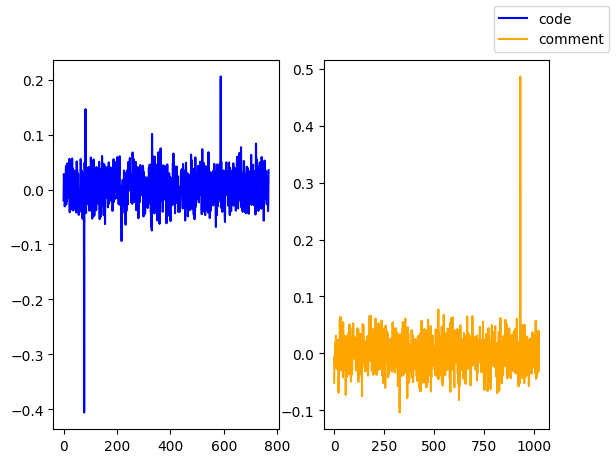

In [16]:
fig = plot_embedding_sample({
    "code_embedding": code.numpy()[0],
    "comment_embedding": comment.numpy()[0],
})
fig.show()